# Stance Detection Using Bidirectional Long Short-Term Memory Followed By Convolutional Neural Network

`Convolutional Neural Networks` `Bidirectional Long Short-Term Memory`  
`AraVec Word Vectors`  
`AraStance Dataset`  
`Stance Detection` `Arabic Language` `Transfer Learning`

---

In this notebook, we rely on a hybrid architecture comprising a very simple bidirectional long short-term memory followed by a convolutional neural network to classify the stances of the articles in the AraStance dataset. The dataset was introduced in the paper:
```
AraStance: A Multi-Country and Multi-Domain Dataset of Arabic Stance Detection for Fact Checking.
```
The pretrained vectors (AraVec project) was introduced in the paper:
```
AraVec: A set of Arabic Word Embedding Models for use in Arabic NLP.
```

## Packages

In [ ]:
!pip install gensim
!pip install pyarabic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 4.1 MB/s eta 0:00:00


In [ ]:
import gensim
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from preprocessing import *
from utils import AraStanceData, evaluate, stance_to_int

## Raw data

- Download the raw data:



In [ ]:
!wget https://github.com/Tariq60/arastance/archive/refs/heads/main.zip
!unzip /content/main.zip

--2024-11-13 07:05:19--  https://github.com/Tariq60/arastance/archive/refs/heads/main.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/Tariq60/arastance/zip/refs/heads/main [following]
--2024-11-13 07:05:19--  https://codeload.github.com/Tariq60/arastance/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 20.205.243.165
Connecting to codeload.github.com (codeload.github.com)|20.205.243.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip’

main.zip                [      <=>           ]  14.09M  3.19MB/s    in 4.4s    

2024-11-13 07:05:25 (3.19 MB/s) - ‘main.zip’ saved [14776886]

Archive:  /content/main.zip
cfb85ecb3043b5def6bb619afca86547cc330738
   creating: arastance-main/
  inflating: arastance-main/README.md  
   crea

- Let's start by reading the raw data:

In [ ]:
raw_train = AraStanceData("/content/arastance-main/data/train.jsonl")
raw_val = AraStanceData("/content/arastance-main/data/dev.jsonl")
raw_test = AraStanceData("/content/arastance-main/data/test.jsonl")

print(f'# training instances: {len(raw_train.stances)}')
print(f'# validation instances: {len(raw_val.stances)}')
print(f'# testing instances: {len(raw_test.stances)}')

# training instances: 2848
# validation instances: 569
# testing instances: 646


- Let's see an instance from the data:

In [ ]:
instance_no = 90
print(f"Claim text: {raw_train.claims[raw_train.article_claim[instance_no]]}")
print(f"Article text: {raw_train.articles[instance_no]}")
print(f"Stance: {raw_train.stances[instance_no]}")

Claim text: شخص بيلعب باليه في شارع التجمع الخامس
Article text: "هل يحبني"؟ سؤال تطرحه المرأة على نفسها مع بداية ميلاد مشاعر إعجاب بشخص ما، وبوادر نشوء علاقة. لكن أحيانا يحتاج الرجل لوقت طويل ليظهر مشاعره الحقيقية بوضوح، فما هي العلامات التي تدلك على أنه لا يستحقك أو أنه يحبك بالفعل؟ تردد الرجل في إظهار مشاعره تجاه المرأة، مسألة محيرة جدا للمرأة. وقد يكون هذا التردد مؤشرا على التأني في المشاعر أو عدم وجود مشاعر حقيقية من الأساس، فكيف تحدد المرأة هذا الأمر. ثمة بعض العلامات التي تؤكد أن هذا الرجل لا يستحق أن تنتظريه، ومن بينها: دائم الانتقاد: الرجل الذي لا يكف عن انتقاد مظهرك وقوامك وملابسك، لا يحبك بالتأكيد. فالقاعدة الأساسية هي أن الرجل عندما يحبك فهو يحب حتى عيوبك. يهتم بنفسه فقط: الرجل الذي لا يبذل أي مجهود في محاولة مقابلتك، وعندما يقابلك بالصدفة يحدد بحسب وقته ورغباته، المكان الذي تتقابلان فيه وموضوعات الحوار، هو بالتأكيد لم يصل لمرحلة كافية من الاهتمام بك، وفقا للنقاط التي رصدها موقع "غوفيمنين" الألماني. لا يرغب في معرفة عائلتك وأصدقائك: عندما لا يهتم الرجل بالتعرف على عائلتك وأص

- Thus, the instances are triplets, Claim/Article/Stance.
- Note that the original language of the data is Arabic.

## Embedding layer

- We will use AraVec pretrained word vectors to represent the input.

### Preprocessing

- To increase the hit rate between the words in our raw data and the tokens (i.e. the keys in AraVec dictionary) in AraVec dictionary, we need to preprocess the data in a way similar to the preprocessing performed to produce those tokens.

- Let's use the following function to preprocess the training, validation, and testing data:

In [ ]:
# this function is resposible for the preprocessing routine
def preprocess(instances):
  instances = list(map(remove_puncuation, instances))
  instances = list(map(remove_diacritics, instances))
  instances = list(map(remove_longation, instances))
  instances = list(map(remove_unicode_codes, instances))
  instances = list(map(process_numerals, instances))
  instances = list(map(normalize, instances))
  instances = list(map(remove_extra_spaces, instances))
  return instances

- Before preprocessing each claim article pair, we need to concatenate them.

In [ ]:
# preprocess training data
train_instances = [raw_train.claims[raw_train.article_claim[idx]] + " " + article \
                  for idx, article in enumerate(raw_train.articles)]
preprocessed_train_instances = preprocess(train_instances)

# preprocess validation data
val_instances = [raw_val.claims[raw_val.article_claim[idx]] + " " + article \
                  for idx, article in enumerate(raw_val.articles)]
preprocessed_val_instances = preprocess(val_instances)

# preprocess testing data
test_instances = [raw_test.claims[raw_test.article_claim[idx]] + " " + article \
                  for idx, article in enumerate(raw_test.articles)]
preprocessed_test_instances = preprocess(test_instances)

- Let's see a preprocessed instance:

In [ ]:
instance_no = 90
print(f"Claim Article text: {preprocessed_train_instances[instance_no]}")
print(f"Stance: {raw_train.stances[instance_no]}")

Claim Article text: شخص بيلعب باليه في شارع التجمع الخامس هل يحبني ؟ سؤال تطرحه المراه علي نفسها مع بدايه ميلاد مشاعر اعجاب بشخص ما وبوادر نشوء علاقه لكن احيانا يحتاج الرجل لوقت طويل ليظهر مشاعره الحقيقيه بوضوح فما هي العلامات التي تدلك علي انه لا يستحقك او انه يحبك بالفعل ؟ تردد الرجل في اظهار مشاعره تجاه المراه مساله محيره جدا للمراه وقد يكون هذا التردد مؤشرا علي التاني في المشاعر او عدم وجود مشاعر حقيقيه من الاساس فكيف تحدد المراه هذا الامر ثمه بعض العلامات التي تؤكد ان هذا الرجل لا يستحق ان تنتظريه ومن بينها دائم الانتقاد الرجل الذي لا يكف عن انتقاد مظهرك وقوامك وملابسك لا يحبك بالتاكيد فالقاعده الاساسيه هي ان الرجل عندما يحبك فهو يحب حتي عيوبك يهتم بنفسه فقط الرجل الذي لا يبذل اي مجهود في محاوله مقابلتك وعندما يقابلك بالصدفه يحدد بحسب وقته ورغباته المكان الذي تتقابلان فيه وموضوعات الحوار هو بالتاكيد لم يصل لمرحله كافيه من الاهتمام بك وفقا للنقاط التي رصدها موقع غوفيمنين الالماني لا يرغب في معرفه عائلتك واصدقائك عندما لا يهتم الرجل بالتعرف علي عائلتك واصدقائك المقربين فهذا دليل علي

### Initialization

- Download the pretrained vectors first:

In [ ]:
!wget "https://bakrianoo.ewr1.vultrobjects.com/aravec/full_uni_cbow_300_wiki.zip"
!unzip "full_uni_cbow_300_wiki.zip"

--2024-11-13 07:06:34--  https://bakrianoo.ewr1.vultrobjects.com/aravec/full_uni_cbow_300_wiki.zip
Resolving bakrianoo.ewr1.vultrobjects.com (bakrianoo.ewr1.vultrobjects.com)... 108.61.0.122, 2001:19f0:0:22::100
Connecting to bakrianoo.ewr1.vultrobjects.com (bakrianoo.ewr1.vultrobjects.com)|108.61.0.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 720915733 (688M) [application/zip]
Saving to: ‘full_uni_cbow_300_wiki.zip’

full_uni_cbow_300_w 100%[===================>] 687.52M  12.7MB/s    in 50s     

2024-11-13 07:07:26 (13.7 MB/s) - ‘full_uni_cbow_300_wiki.zip’ saved [720915733/720915733]

Archive:  full_uni_cbow_300_wiki.zip
  inflating: full_uni_cbow_300_wiki.mdl  
  inflating: full_uni_cbow_300_wiki.mdl.trainables.syn1neg.npy  
  inflating: full_uni_cbow_300_wiki.mdl.wv.vectors.npy  


- Load the pretrained vectors:

In [ ]:
embedding_model = gensim.models.Word2Vec.load("full_uni_cbow_300_wiki.mdl")
print("AraVect project contains",len(embedding_model.wv.index_to_key),"tokens")

AraVect project contains 320636 tokens


- We need to decide on the words we are going to use in the final representation of each instance, so we will use a vectorization layer to learn a vocabulary from our training data. We allowed 30K tokens in our vocabulary.
- We also going to need a word index, which maps words to indices like `{word1-->idx1, word2-->idx2, ...}`. The indices will be used to store the vector representation of each word in the embedding matrix.

In [ ]:
# Option 1 using TextVectorization layer
# max_tokens represents the maximum size of the vocabulary
vectorizer = tf.keras.layers.TextVectorization(max_tokens=20000, output_sequence_length=150, standardize=None)
text_ds = tf.data.Dataset.from_tensor_slices(preprocessed_train_instances).batch(128)

# learn the vocabulary based on the training data
vectorizer.adapt(text_ds)

voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

# Option 2 using NLTK tokenizer
# import nltk
# from nltk import  word_tokenize
# nltk.download('punkt')

# def tokenization(text):
#   return word_tokenize(text)

# train_tokenized = list(map(tokenization, train_samples))
# tokens = [token for sublist in train_tokenized for token in sublist]
# tokens = set(tokens)
# word_index = dict(zip(tokens, range(len(tokens))))
# len(tokens)

- We are now ready to create an embedding matrix which maps token indices of our vocabulary to pretrained word vectors from AraVec project:

In [ ]:
num_tokens = len(voc) + 2
embedding_dim = 300
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
  if embedding_model.wv.__contains__(word):
    embedding_matrix[i] = embedding_model.wv.get_vector(word)
    hits += 1
  else:
    misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 19860 words (140 misses)


- Let's see the representation of a random token:

In [ ]:
print(f"The word 'يناير' is at index {word_index['يناير']}")
print(f"The vector representation of 'يناير' is {embedding_matrix[word_index['يناير']]}")

The word 'يناير' is at index 370
The vector representation of 'يناير' is [ 0.51005375  1.19242501 -1.1961081   1.54170382  0.83659106  0.98661953
  2.35651946  1.40938616  0.46756575 -1.15503812 -2.05074883  1.79200149
  2.26149178 -2.35674977 -1.54589176  1.4476347   0.17506057 -1.03495252
  0.14923877  0.50402081 -1.22456503 -2.81537771 -0.14951073 -0.64106113
 -1.78856778 -3.01331806  1.09811449  0.82774377 -2.12052202  0.10627326
 -0.3470996   0.56881094  0.70859134  1.14366102 -1.39147961 -0.93328577
 -0.41829142  0.35251924 -5.5062871  -0.01710663  1.58901513 -1.04543102
 -1.53454065 -0.88687831 -0.14384538  1.67812455  0.39177114 -1.44210482
  1.21285033  0.28208566 -0.27708358  1.30340207 -0.0260686   1.36871862
  0.28364053  2.31196856 -1.6904012  -1.23371506 -0.75107098  1.8761574
 -0.73244673 -0.20883329 -0.66077822  1.06395638 -1.04924607  0.86401767
 -1.4296838  -0.46038389  1.66213858  2.74791789  2.06197238  1.3414613
 -1.38134551 -1.60160661 -2.83723998  1.29322004 -1.6

- Let's initialize our embedding layer with the embedding matrix:

In [ ]:
embedding_layer = tf.keras.layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

## Datasets

In [ ]:
batch_size = 64

- Before creating the dataset, we need to vectorize the training, validation, and testing data using the adapted vectorizer. This means replace every word in an instance by its index in the word index:

In [ ]:
x_train = vectorizer(np.array([[s] for s in preprocessed_train_instances])).numpy()
x_val = vectorizer(np.array([[s] for s in preprocessed_val_instances])).numpy()
x_test = vectorizer(np.array([[s] for s in preprocessed_test_instances])).numpy()

- Let's see a vectorized instance:

In [ ]:
instance_no = 90
print(f"Original preprocessed instance: {preprocessed_train_instances[instance_no]}")
print(f"Vectorized instance: {x_train[instance_no]}")

Original preprocessed instance: شخص بيلعب باليه في شارع التجمع الخامس هل يحبني ؟ سؤال تطرحه المراه علي نفسها مع بدايه ميلاد مشاعر اعجاب بشخص ما وبوادر نشوء علاقه لكن احيانا يحتاج الرجل لوقت طويل ليظهر مشاعره الحقيقيه بوضوح فما هي العلامات التي تدلك علي انه لا يستحقك او انه يحبك بالفعل ؟ تردد الرجل في اظهار مشاعره تجاه المراه مساله محيره جدا للمراه وقد يكون هذا التردد مؤشرا علي التاني في المشاعر او عدم وجود مشاعر حقيقيه من الاساس فكيف تحدد المراه هذا الامر ثمه بعض العلامات التي تؤكد ان هذا الرجل لا يستحق ان تنتظريه ومن بينها دائم الانتقاد الرجل الذي لا يكف عن انتقاد مظهرك وقوامك وملابسك لا يحبك بالتاكيد فالقاعده الاساسيه هي ان الرجل عندما يحبك فهو يحب حتي عيوبك يهتم بنفسه فقط الرجل الذي لا يبذل اي مجهود في محاوله مقابلتك وعندما يقابلك بالصدفه يحدد بحسب وقته ورغباته المكان الذي تتقابلان فيه وموضوعات الحوار هو بالتاكيد لم يصل لمرحله كافيه من الاهتمام بك وفقا للنقاط التي رصدها موقع غوفيمنين الالماني لا يرغب في معرفه عائلتك واصدقائك عندما لا يهتم الرجل بالتعرف علي عائلتك واصدقائك المقربين ف

- Let's initialize the datasets we are going to use for the training and testing:

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_size = len(raw_train.stances)

train_labels = [stance_to_int[s] for s in raw_train.stances]
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels))
train_dataset = train_dataset.shuffle(train_size)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)

val_labels = [stance_to_int[s] for s in raw_val.stances]
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, val_labels))
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

test_labels = [stance_to_int[s] for s in raw_test.stances]
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, test_labels))
test_dataset = test_dataset.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

## Model

- Now the datasets are ready, we can work on the model:

In [ ]:
lr = 1e-4
epochs = 100

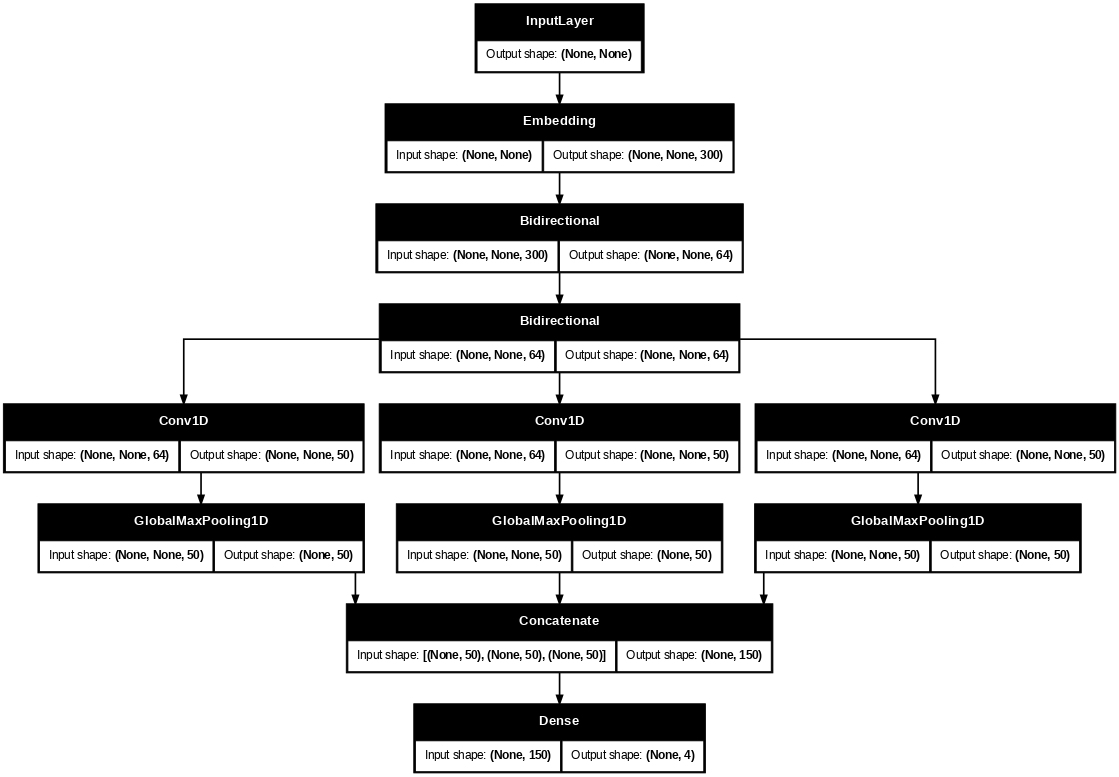

In [ ]:
int_sequences_input = tf.keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)

lstm_output_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(embedded_sequences)
lstm_output_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(lstm_output_1)

conv1 = tf.keras.layers.Conv1D(50, 2, activation="relu", use_bias=True)(lstm_output_2)
conv2 = tf.keras.layers.Conv1D(50, 3, activation="relu", use_bias=True)(lstm_output_2)
conv3 = tf.keras.layers.Conv1D(50, 4, activation="relu", use_bias=True)(lstm_output_2)

pool1 = tf.keras.layers.GlobalMaxPooling1D()(conv1)
pool2 = tf.keras.layers.GlobalMaxPooling1D()(conv2)
pool3 = tf.keras.layers.GlobalMaxPooling1D()(conv3)

concatenated = tf.keras.layers.Concatenate(axis=1)([pool1, pool2, pool3])

logits = tf.keras.layers.Dense(4)(concatenated)

model = tf.keras.models.Model(inputs=int_sequences_input, outputs=logits)

tf.keras.utils.plot_model(model, show_shapes=True, dpi=60)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, None, 300)      │      6,000,600 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, None, 64)       │         85,248 │ embedding[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, None, 64)       │         24,832 │ bidirectional[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, None, 50)       │          6,450 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, None, 50)       │          9,650 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, None, 50)       │         12,850 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 50)             │              0 │ conv1d[0][0]           │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_1    │ (None, 50)             │              0 │ conv1d_1[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_2    │ (None, 50)             │              0 │ conv1d_2[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 150)            │              0 │ global_max_pooling1d[… │
│                           │                        │                │ global_max_pooling1d_… │
│                           │                        │                │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 4)              │            604 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,140,234 (23.42 MB)

 Trainable params: 139,634 (545.45 KB)

 Non-trainable params: 6,000,600 (22.89 MB)

## Training

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])

In [ ]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=5)]
history=model.fit(
  x=train_dataset,
  validation_data=val_dataset,
  epochs=epochs,
  callbacks=callbacks,
)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.2896 - loss: 1.4333 - val_accuracy: 0.5114 - val_loss: 1.1991
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5510 - loss: 1.0993 - val_accuracy: 0.5167 - val_loss: 1.1781
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5600 - loss: 1.0448 - val_accuracy: 0.5378 - val_loss: 1.1558
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5894 - loss: 1.0021 - val_accuracy: 0.5395 - val_loss: 1.1337
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6066 - loss: 0.9594 - val_accuracy: 0.5431 - val_loss: 1.1097
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6232 - loss: 0.9144 - val_accuracy: 0.5606 - val_loss: 1.0845
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6529 - loss: 0.8671 - val_accuracy: 0.5694 - val_loss: 1.0592
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6825 - loss: 0.8194 - val_accuracy: 0.

- Plot learning curves:

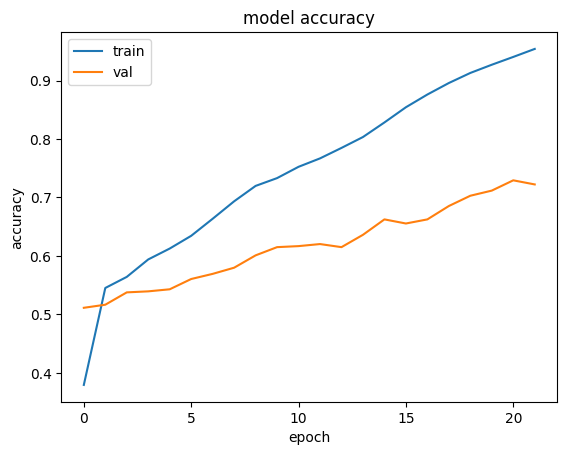

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

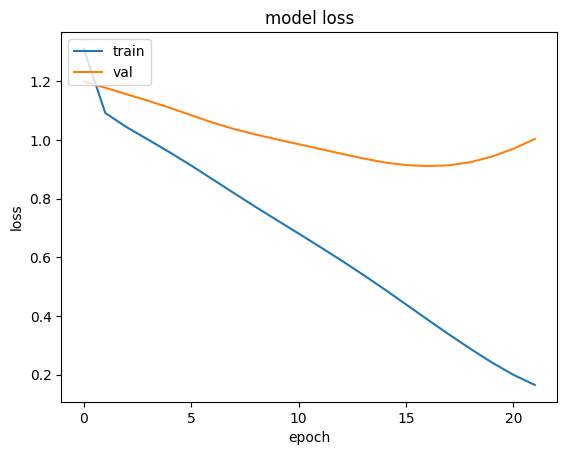

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Evaluation

In [ ]:
loss, accuracy, f1score, mf1score = evaluate(model, val_dataset, val_labels)
print("Loss                       :", loss)
print("Accuracy                   :", accuracy)
print("F1 score                   :", f1score)
print("Macro F1 score             :", mf1score)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7109 - loss: 1.0808
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
Loss                       : 1.0032150745391846
Accuracy                   : 0.7223198594024605
F1 score                   : [0.69144981 0.65217391 0.43076923 0.81530782]
Macro F1 score             : 0.647425194559651


In [ ]:
loss, accuracy, f1score, mf1score = evaluate(model, test_dataset, test_labels)
print("Loss                       :", loss)
print("Accuracy                   :", accuracy)
print("F1 score                   :", f1score)
print("Macro F1 score             :", mf1score)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7926 - loss: 0.7410
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Loss                       : 0.8966706991195679
Accuracy                   : 0.7554179566563467
F1 score                   : [0.71044776 0.57657658 0.45045045 0.84897959]
Macro F1 score             : 0.6466135950144478


- Let's see the confusion matrix on the testing dataset:

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


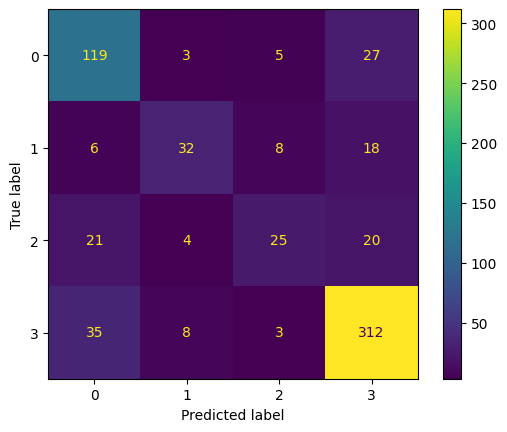

In [ ]:
y_pred = model.predict(test_dataset)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(test_labels, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

- The model misclassifyies too many instances from the relatively easy 'unrelated' class.
- It also misclassifies a lot of instances from the 'agree', 'disagree', and 'discuss' classes.
- The confusion matrix suggests that the majority 'unrelated' class, besides the relatively more represented 'agree' class are dominating the dataset.

## A Word on overfitting

- Needs further investigation (next step).
- In [A first thought on overfitting](https://github.com/Ali-Mhrez/Stance-Detection/blob/main/SD_MLP.ipynb), we argue that the performance on the validation set stopped improving due to limits in the dataset, thus it is not clear how much we should attribute the learning curves to overfitting versus model struggling to capture the underlying concepts of the 'disagree' and 'discuss' classes.